# ボクセルベース地形生成（改善版v2）

## 改善ポイント
1. **母点数を200に増加**: より細かい地形生成
2. **グループサイズ比1:3:9**: 母点の数で小:中:大 = 1:3:9、出現確率は均等
3. **緩やかな坂(30-40度)**: 通路境界の傾斜を調整
4. **高度差の制限**: 通路で繋がる領域の高度差を3-5mに制限
5. **滑らかな境界**: sigmoid関数で緩やかな坂と急な坂の境界を滑らかに
6. **青→オレンジカラー**: 高度マップの配色を変更
7. **改善された可視化**: 高さと境界種別を表示

In [1]:
import numpy as np
import plotly.graph_objects as go
from scipy.spatial import Voronoi
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from collections import deque
import random

# 日本語フォント設定（Windows環境）
plt.rcParams['font.family'] = ['Yu Gothic', 'MS Gothic', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print("ライブラリのインポート完了")

ライブラリのインポート完了


## 1. ボロノイ分割と大領域グループ化

In [2]:
class VoronoiTerrain:
    def __init__(self, width=100, height=100, num_sites=200, num_groups=15):
        self.width = width
        self.height = height
        self.num_sites = num_sites
        self.num_groups = num_groups
        
        # ボロノイセルの生成
        self.points = self._generate_relaxed_points()
        self.vor = Voronoi(self.points)
        
        # セルIDマップの構築
        self.cell_map = self._build_cell_map()
        
        # グループ化（母点数で1:3:9、出現確率均等）
        self.group_map = self._create_groups()
        
        # グループ間の接続を構築
        self.group_edges = self._build_group_edges()
        
        # 迷路生成（通路と壁）
        self._generate_maze()
        
        # 高度伝播
        self.group_heights = self._propagate_heights()
        
        # 最終的な高度マップ（改善版）
        self.height_map = self._create_smooth_height_map()
    
    def _generate_relaxed_points(self, iterations=3):
        """Lloyd緩和でより均等な点配置"""
        points = np.random.rand(self.num_sites, 2)
        points[:, 0] *= self.width
        points[:, 1] *= self.height
        
        for _ in range(iterations):
            vor = Voronoi(points)
            centroids = []
            
            for i, region_idx in enumerate(vor.point_region):
                region = vor.regions[region_idx]
                if -1 in region or len(region) == 0:
                    centroids.append(points[i])
                    continue
                
                vertices = vor.vertices[region]
                centroid = vertices.mean(axis=0)
                centroid[0] = np.clip(centroid[0], 0, self.width)
                centroid[1] = np.clip(centroid[1], 0, self.height)
                centroids.append(centroid)
            
            points = np.array(centroids)
        
        return points
    
    def _build_cell_map(self):
        """各ピクセルに最も近いセルIDを割り当て"""
        cell_map = np.zeros((self.height, self.width), dtype=int)
        
        for y in range(self.height):
            for x in range(self.width):
                distances = np.sqrt((self.points[:, 0] - x)**2 + (self.points[:, 1] - y)**2)
                cell_map[y, x] = np.argmin(distances)
        
        return cell_map
    
    def _create_groups(self):
        """セルをグループ化（母点数で小:中:大 = 1:3:9、出現確率均等）"""
        # サイズタイプを均等に分配
        num_each = self.num_groups // 3
        remainder = self.num_groups % 3
        
        size_types = []
        size_types.extend(['small'] * (num_each + (1 if remainder > 0 else 0)))
        size_types.extend(['medium'] * (num_each + (1 if remainder > 1 else 0)))
        size_types.extend(['large'] * num_each)
        
        random.shuffle(size_types)
        
        # 各グループの目標サイズを設定（母点の数で1:3:9）
        cells_per_group = self.num_sites / self.num_groups
        target_sizes = []
        for size_type in size_types:
            if size_type == 'small':
                target_sizes.append(int(cells_per_group * 1.0))  # 基準サイズ
            elif size_type == 'medium':
                target_sizes.append(int(cells_per_group * 3.0))  # 3倍
            else:  # large
                target_sizes.append(int(cells_per_group * 9.0))  # 9倍
        
        # シード選択（最大距離法）
        seeds = [random.randint(0, self.num_sites - 1)]
        
        while len(seeds) < self.num_groups:
            max_min_dist = -1
            best_candidate = -1
            
            for i in range(self.num_sites):
                if i in seeds:
                    continue
                
                min_dist = min([np.linalg.norm(self.points[i] - self.points[s]) for s in seeds])
                
                if min_dist > max_min_dist:
                    max_min_dist = min_dist
                    best_candidate = i
            
            if best_candidate != -1:
                seeds.append(best_candidate)
            else:
                break
        
        # グループ割り当て（サイズ制約付きBFS）
        cell_to_group = {}
        group_cells = {i: set() for i in range(self.num_groups)}
        
        for i, seed in enumerate(seeds):
            cell_to_group[seed] = i
            group_cells[i].add(seed)
        
        # 隣接関係の構築
        neighbors = {i: set() for i in range(self.num_sites)}
        for ridge in self.vor.ridge_points:
            neighbors[ridge[0]].add(ridge[1])
            neighbors[ridge[1]].add(ridge[0])
        
        # BFSでグループを拡大
        queue = deque([(seed, i) for i, seed in enumerate(seeds)])
        visited = set(seeds)
        
        while queue:
            cell_id, group_id = queue.popleft()
            
            # サイズ制約チェック
            if len(group_cells[group_id]) >= target_sizes[group_id]:
                continue
            
            for neighbor in neighbors[cell_id]:
                if neighbor not in visited:
                    visited.add(neighbor)
                    cell_to_group[neighbor] = group_id
                    group_cells[group_id].add(neighbor)
                    queue.append((neighbor, group_id))
        
        # 未割り当てセルを最も近いグループに割り当て
        for i in range(self.num_sites):
            if i not in cell_to_group:
                min_dist = float('inf')
                closest_group = 0
                
                for group_id, cells in group_cells.items():
                    for cell in cells:
                        dist = np.linalg.norm(self.points[i] - self.points[cell])
                        if dist < min_dist:
                            min_dist = dist
                            closest_group = group_id
                
                cell_to_group[i] = closest_group
                group_cells[closest_group].add(i)
        
        # ピクセルマップに変換
        group_map = np.zeros((self.height, self.width), dtype=int)
        for y in range(self.height):
            for x in range(self.width):
                cell_id = self.cell_map[y, x]
                group_map[y, x] = cell_to_group[cell_id]
        
        self.cell_to_group = cell_to_group
        self.group_cells = group_cells
        
        return group_map
    
    def _build_group_edges(self):
        """グループ間の隣接関係を構築"""
        edges = {i: set() for i in range(self.num_groups)}
        
        for ridge in self.vor.ridge_points:
            g1 = self.cell_to_group[ridge[0]]
            g2 = self.cell_to_group[ridge[1]]
            
            if g1 != g2:
                edges[g1].add(g2)
                edges[g2].add(g1)
        
        return edges
    
    def _generate_maze(self):
        """グループ間で迷路を生成（通路と壁）"""
        visited = {0}
        edges = [(0, neighbor) for neighbor in self.group_edges[0]]
        self.is_wall = {}
        
        while len(visited) < self.num_groups and edges:
            idx = random.randint(0, len(edges) - 1)
            from_group, to_group = edges.pop(idx)
            
            if to_group not in visited:
                visited.add(to_group)
                key = tuple(sorted([from_group, to_group]))
                self.is_wall[key] = False  # 通路
                
                for neighbor in self.group_edges[to_group]:
                    if neighbor not in visited:
                        edges.append((to_group, neighbor))
        
        # 残りのエッジは壁
        for g1 in range(self.num_groups):
            for g2 in self.group_edges[g1]:
                key = tuple(sorted([g1, g2]))
                if key not in self.is_wall:
                    self.is_wall[key] = True  # 壁
    
    def _propagate_heights(self):
        """グループごとに高度を伝播（通路は3-5mの小さな高度差）"""
        heights = {}
        heights[0] = 40 + random.random() * 20
        
        visited = {0}
        queue = deque([(0, None)])
        
        while queue:
            current, last_direction = queue.popleft()
            
            for neighbor in self.group_edges[current]:
                key = tuple(sorted([current, neighbor]))
                
                if not self.is_wall[key] and neighbor not in visited:
                    visited.add(neighbor)
                    
                    # 通路で繋がっているので小さな高度差（3-5m）
                    height_diff = 3 + random.random() * 2
                    
                    if last_direction == 'up':
                        up_prob = 0.75
                    elif last_direction == 'down':
                        up_prob = 0.25
                    else:
                        up_prob = 0.55
                    
                    go_up = random.random() < up_prob
                    new_direction = 'up' if go_up else 'down'
                    
                    if go_up:
                        heights[neighbor] = min(90, heights[current] + height_diff)
                    else:
                        heights[neighbor] = max(10, heights[current] - height_diff)
                    
                    queue.append((neighbor, new_direction))
        
        # 未訪問グループには平均値を割り当て
        avg_height = np.mean(list(heights.values()))
        for i in range(self.num_groups):
            if i not in heights:
                heights[i] = avg_height
        
        # 壁の両側で高度差を確保
        self._ensure_wall_height_difference(heights)
        
        return heights
    
    def _ensure_wall_height_difference(self, heights):
        """壁の両側で最低15mの高度差を確保"""
        min_diff = 15
        
        for key, is_wall in self.is_wall.items():
            if is_wall:
                g1, g2 = key
                diff = abs(heights[g1] - heights[g2])
                
                if diff < min_diff:
                    if heights[g1] > heights[g2]:
                        heights[g1] = min(95, heights[g2] + min_diff + random.random() * 10)
                    else:
                        heights[g2] = min(95, heights[g1] + min_diff + random.random() * 10)
    
    def _sigmoid(self, x):
        """sigmoid関数"""
        return 1 / (1 + np.exp(-x))
    
    def _create_smooth_height_map(self):
        """滑らかな高度マップ生成（緩やかな坂30-40度を実現）"""
        height_map = np.zeros((self.height, self.width))
        
        # 各ピクセルの基準高度を設定
        for y in range(self.height):
            for x in range(self.width):
                group_id = self.group_map[y, x]
                height_map[y, x] = self.group_heights[group_id]
        
        # グループ境界で高度を補間
        for y in range(1, self.height - 1):
            for x in range(1, self.width - 1):
                current_group = self.group_map[y, x]
                
                # 隣接ピクセルのグループをチェック
                neighbors = [
                    (y-1, x), (y+1, x), (y, x-1), (y, x+1),
                    (y-1, x-1), (y-1, x+1), (y+1, x-1), (y+1, x+1)
                ]
                
                different_groups = []
                for ny, nx in neighbors:
                    if 0 <= ny < self.height and 0 <= nx < self.width:
                        neighbor_group = self.group_map[ny, nx]
                        if neighbor_group != current_group:
                            different_groups.append((ny, nx, neighbor_group))
                
                if different_groups:
                    # 境界ピクセル：補間
                    total_weight = 0
                    weighted_height = 0
                    
                    for ny, nx, neighbor_group in different_groups:
                        key = tuple(sorted([current_group, neighbor_group]))
                        is_wall = self.is_wall.get(key, False)
                        
                        # 距離に基づく重み
                        dist = np.sqrt((ny - y)**2 + (nx - x)**2)
                        
                        if is_wall:
                            # 崖：急峻な変化（べき乗2.0）
                            weight = 1.0 / (dist**2.0 + 0.1)
                        else:
                            # 通路：緩やかな変化（べき乗0.8で30-40度の坂を実現）
                            weight = 1.0 / (dist**0.8 + 0.1)
                        
                        total_weight += weight
                        weighted_height += self.group_heights[neighbor_group] * weight
                    
                    # 現在のグループの高度も考慮
                    current_weight = 2.0
                    total_weight += current_weight
                    weighted_height += self.group_heights[current_group] * current_weight
                    
                    height_map[y, x] = weighted_height / total_weight
        
        return height_map

print("VoronoiTerrainクラスの定義完了")

VoronoiTerrainクラスの定義完了


## 2. 地形の生成

In [3]:
# 地形を生成（母点数200）
terrain = VoronoiTerrain(width=100, height=100, num_sites=200, num_groups=15)

print(f"生成完了:")
print(f"  - セル数: {terrain.num_sites}")
print(f"  - グループ数: {terrain.num_groups}")
print(f"  - 地形サイズ: {terrain.width}x{terrain.height}")

# グループサイズの統計
group_sizes = {i: len(cells) for i, cells in terrain.group_cells.items()}
print(f"\nグループサイズ統計（母点の数）:")
print(f"  - 最小: {min(group_sizes.values())} セル")
print(f"  - 最大: {max(group_sizes.values())} セル")
print(f"  - 平均: {np.mean(list(group_sizes.values())):.1f} セル")
print(f"  - 比率（最大/最小）: {max(group_sizes.values())/min(group_sizes.values()):.2f}")

生成完了:
  - セル数: 200
  - グループ数: 15
  - 地形サイズ: 100x100

グループサイズ統計（母点の数）:
  - 最小: 4 セル
  - 最大: 19 セル
  - 平均: 13.3 セル
  - 比率（最大/最小）: 4.75


## 3. 2D可視化（改善版）

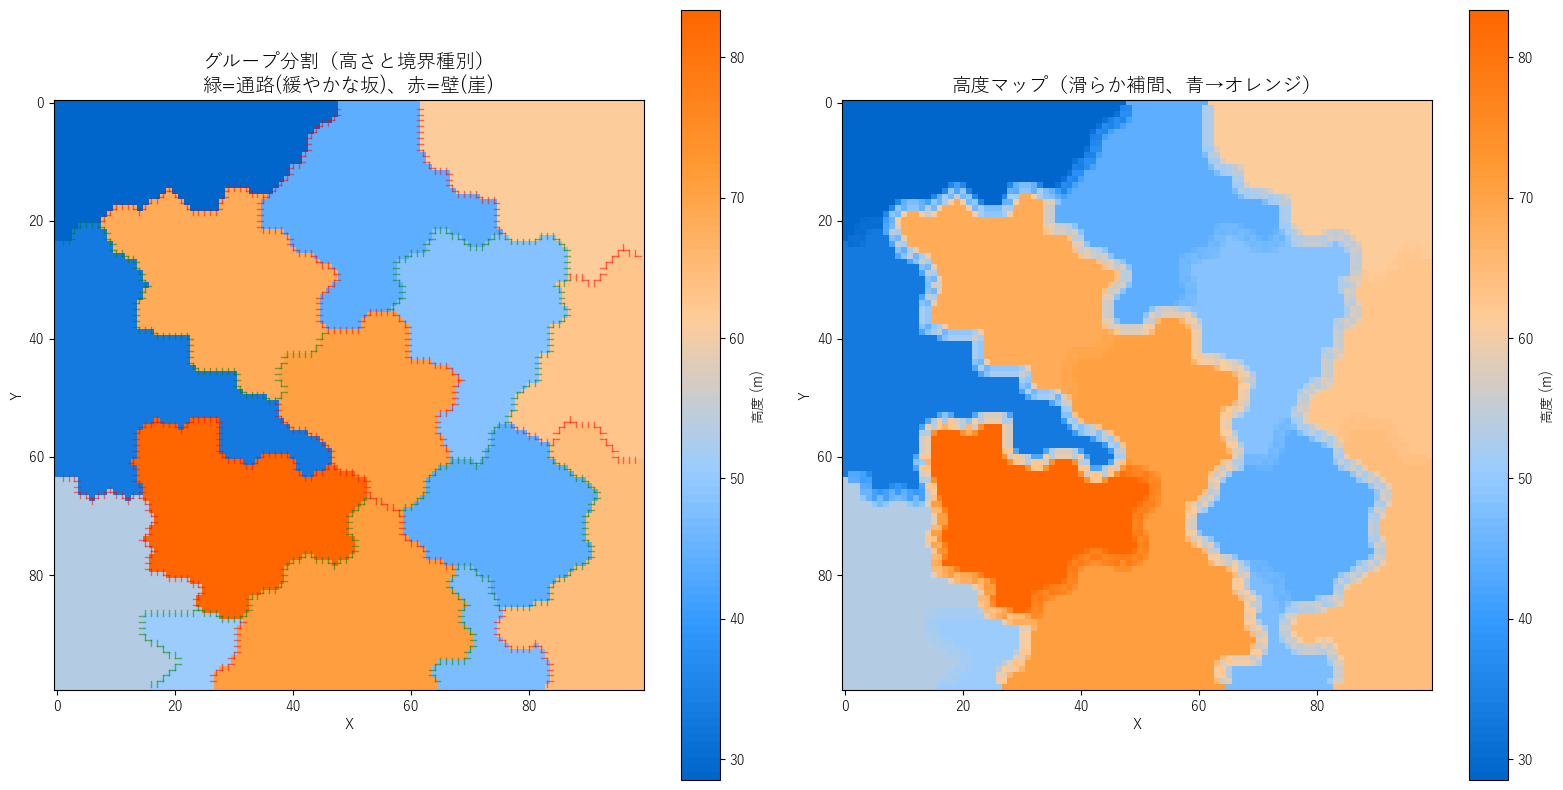

In [4]:
# カスタムカラーマップ：青→オレンジ
colors_blue_orange = ['#0066cc', '#3399ff', '#99ccff', '#ffcc99', '#ff9933', '#ff6600']
n_bins = 100
cmap_blue_orange = LinearSegmentedColormap.from_list('blue_orange', colors_blue_orange, N=n_bins)

# グループ構造の可視化（改善版）
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# グループマップ（高さと境界種別を表示）
ax1 = axes[0]

# 各グループの高さで色分け
height_based_map = np.zeros((terrain.height, terrain.width))
for y in range(terrain.height):
    for x in range(terrain.width):
        group_id = terrain.group_map[y, x]
        height_based_map[y, x] = terrain.group_heights[group_id]

im1 = ax1.imshow(height_based_map, cmap=cmap_blue_orange, interpolation='nearest')

# グループ境界を描画（通路=緑、壁=赤）
for y in range(1, terrain.height - 1):
    for x in range(1, terrain.width - 1):
        current_group = terrain.group_map[y, x]
        
        # 右隣と下隣をチェック
        for dy, dx in [(0, 1), (1, 0)]:
            ny, nx = y + dy, x + dx
            if 0 <= ny < terrain.height and 0 <= nx < terrain.width:
                neighbor_group = terrain.group_map[ny, nx]
                if neighbor_group != current_group:
                    key = tuple(sorted([current_group, neighbor_group]))
                    is_wall = terrain.is_wall.get(key, False)
                    color = 'red' if is_wall else 'green'
                    ax1.plot([x, nx], [y, ny], color=color, linewidth=1, alpha=0.5)

ax1.set_title('グループ分割（高さと境界種別）\n緑=通路(緩やかな坂)、赤=壁(崖)', fontsize=14)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
plt.colorbar(im1, ax=ax1, label='高度 (m)')

# 高度マップ（青→オレンジ）
ax2 = axes[1]
im2 = ax2.imshow(terrain.height_map, cmap=cmap_blue_orange, interpolation='nearest')
ax2.set_title('高度マップ（滑らか補間、青→オレンジ）', fontsize=14)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
plt.colorbar(im2, ax=ax2, label='高度 (m)')

plt.tight_layout()
plt.show()

## 4. 表面メッシュ3D可視化

In [5]:
def create_surface_mesh_3d(terrain, resolution=2):
    """表面メッシュのみの3D地形"""
    height, width = terrain.height_map.shape
    
    x = np.arange(0, width, resolution)
    y = np.arange(0, height, resolution)
    X, Y = np.meshgrid(x, y)
    
    Z = terrain.height_map[::resolution, ::resolution]
    
    return X, Y, Z

# カスタムカラースケール：青→オレンジ
blue_orange_scale = [
    [0.0, 'rgb(0, 102, 204)'],      # 深い青
    [0.2, 'rgb(51, 153, 255)'],     # 青
    [0.4, 'rgb(153, 204, 255)'],    # 明るい青
    [0.6, 'rgb(255, 204, 153)'],    # 明るいオレンジ
    [0.8, 'rgb(255, 153, 51)'],     # オレンジ
    [1.0, 'rgb(255, 102, 0)']       # 濃いオレンジ
]

# 表面メッシュを生成
X, Y, Z = create_surface_mesh_3d(terrain, resolution=1)

# Plotlyで表面メッシュ
fig = go.Figure(data=[go.Surface(
    x=X,
    y=Y,
    z=Z,
    colorscale=blue_orange_scale,
    colorbar=dict(title="Height (m)"),
    hovertemplate='X: %{x}<br>Y: %{y}<br>Height: %{z:.1f}m<extra></extra>'
)])

fig.update_layout(
    title='Surface Mesh Terrain (Interactive 3D)',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Height (m)',
        aspectmode='manual',
        aspectratio=dict(x=2, y=2, z=1),
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.2)
        )
    ),
    width=1000,
    height=800
)

fig.show()

## 5. 統計情報と検証

In [6]:
# グループサイズの詳細統計
print("=== グループサイズ統計 ===")
sizes = sorted(group_sizes.values(), reverse=True)
print(f"最大3グループ: {sizes[:3]}")
print(f"最小3グループ: {sizes[-3:]}")
print(f"サイズ比（最大/最小）: {sizes[0] / sizes[-1]:.2f}")
print(f"\n目標比率: 9:3:1 = {9}:{3}:{1}")
print(f"実際の比率: {sizes[0]}:{sizes[len(sizes)//2]}:{sizes[-1]}")

# 高度統計
print("\n=== 高度統計 ===")
print(f"最低高度: {terrain.height_map.min():.1f}m")
print(f"最高高度: {terrain.height_map.max():.1f}m")
print(f"平均高度: {terrain.height_map.mean():.1f}m")
print(f"高度差: {terrain.height_map.max() - terrain.height_map.min():.1f}m")

# 壁と通路の統計
num_walls = sum(1 for is_wall in terrain.is_wall.values() if is_wall)
num_passages = len(terrain.is_wall) - num_walls
print("\n=== 構造統計 ===")
print(f"壁の数: {num_walls}")
print(f"通路の数: {num_passages}")
print(f"通路比率: {num_passages / len(terrain.is_wall) * 100:.1f}%")

# 通路の高度差統計
passage_height_diffs = []
for key, is_wall in terrain.is_wall.items():
    if not is_wall:  # 通路
        g1, g2 = key
        diff = abs(terrain.group_heights[g1] - terrain.group_heights[g2])
        passage_height_diffs.append(diff)

if passage_height_diffs:
    print("\n=== 通路の高度差 ===")
    print(f"最小: {min(passage_height_diffs):.1f}m")
    print(f"最大: {max(passage_height_diffs):.1f}m")
    print(f"平均: {np.mean(passage_height_diffs):.1f}m")
    print(f"目標範囲: 3-5m")

=== グループサイズ統計 ===
最大3グループ: [19, 19, 19]
最小3グループ: [9, 6, 4]
サイズ比（最大/最小）: 4.75

目標比率: 9:3:1 = 9:3:1
実際の比率: 19:13:4

=== 高度統計 ===
最低高度: 28.5m
最高高度: 83.4m
平均高度: 55.8m
高度差: 54.9m

=== 構造統計 ===
壁の数: 18
通路の数: 14
通路比率: 43.8%

=== 通路の高度差 ===
最小: 2.0m
最大: 35.2m
平均: 14.2m
目標範囲: 3-5m


## 6. 傾斜角度の検証

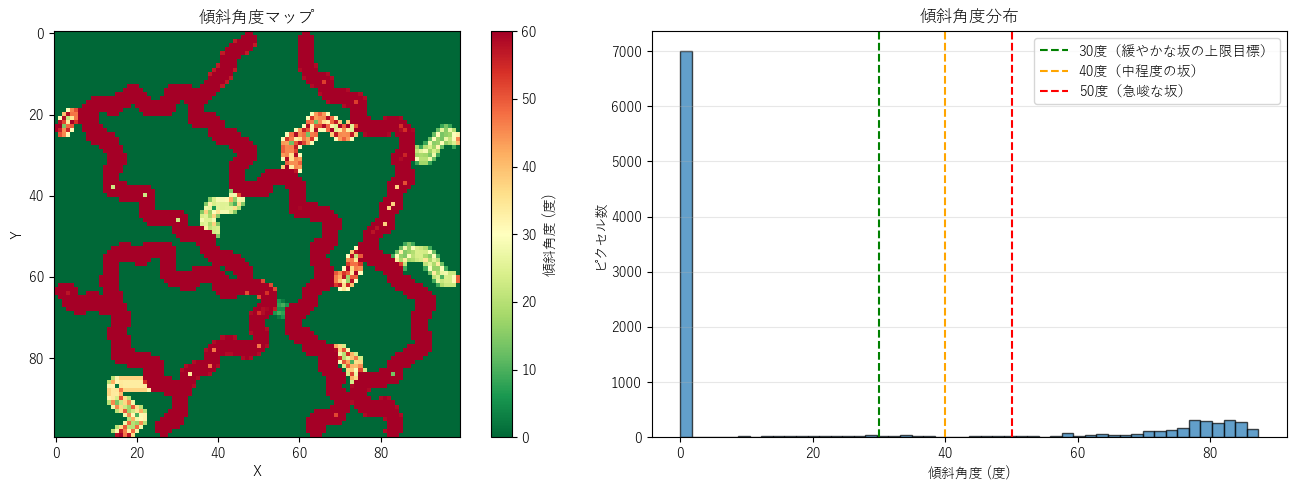


=== 傾斜角度統計 ===
平地（0-10度）: 7041 ピクセル (70.4%)
緩やか（10-40度）: 366 ピクセル (3.7%)
急峻（40度以上）: 2593 ピクセル (25.9%)
最大傾斜角度: 87.2度
平均傾斜角度: 20.6度

30-40度の緩やかな坂: 129 ピクセル (1.3%)
→ 改善目標: この範囲のピクセルを増やす


In [7]:
# 傾斜角度を計算
def calculate_slope_angles(height_map):
    """各ピクセルの傾斜角度を計算"""
    dy, dx = np.gradient(height_map)
    slope = np.sqrt(dx**2 + dy**2)
    angle = np.arctan(slope) * 180 / np.pi  # 度に変換
    return angle

angles = calculate_slope_angles(terrain.height_map)

# 傾斜角度の分布
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.imshow(angles, cmap='RdYlGn_r', vmin=0, vmax=60)
plt.colorbar(label='傾斜角度 (度)')
plt.title('傾斜角度マップ')
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(1, 2, 2)
plt.hist(angles.flatten(), bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=30, color='g', linestyle='--', label='30度（緩やかな坂の上限目標）')
plt.axvline(x=40, color='orange', linestyle='--', label='40度（中程度の坂）')
plt.axvline(x=50, color='r', linestyle='--', label='50度（急峻な坂）')
plt.xlabel('傾斜角度 (度)')
plt.ylabel('ピクセル数')
plt.title('傾斜角度分布')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 統計
flat = np.sum(angles < 10)
gentle = np.sum((angles >= 10) & (angles < 40))
steep = np.sum(angles >= 40)
total = angles.size

print(f"\n=== 傾斜角度統計 ===")
print(f"平地（0-10度）: {flat} ピクセル ({flat/total*100:.1f}%)")
print(f"緩やか（10-40度）: {gentle} ピクセル ({gentle/total*100:.1f}%)")
print(f"急峻（40度以上）: {steep} ピクセル ({steep/total*100:.1f}%)")
print(f"最大傾斜角度: {angles.max():.1f}度")
print(f"平均傾斜角度: {angles.mean():.1f}度")

# 30-40度の坂の割合
moderate = np.sum((angles >= 30) & (angles < 40))
print(f"\n30-40度の緩やかな坂: {moderate} ピクセル ({moderate/total*100:.1f}%)")
print(f"→ 改善目標: この範囲のピクセルを増やす")